<a href="https://colab.research.google.com/github/giuliovv/ANNDL_competitions/blob/master/data_based/notebooks/modello_data_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import base64
import requests

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")

Please check this box if the notebook is executed locally, note that on colab the files from github may not be available due to the repository being private.

In [64]:
local = False #@param {type:"boolean"}

In [65]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

In [66]:
xynames = ["i", "y"]

In [67]:
def get_values_from_github(url_x, url_y, url_gate=None, Vin=None, local=False):
  if not local:
    X_read = requests.get("https://raw.githubusercontent.com/giuliovv/bldc_project_work/master/data/" + url_x + ".csv").text
    Y_read = requests.get("https://raw.githubusercontent.com/giuliovv/bldc_project_work/master/data/" + url_y + ".csv").text
    if url_gate:
      gate = requests.get("https://raw.githubusercontent.com/giuliovv/bldc_project_work/master/data/" + url_gate + ".csv").text
    if Vin:
      Vin = requests.get("https://raw.githubusercontent.com/giuliovv/bldc_project_work/master/data/" + Vin + ".csv").text
  else:
    X_read = open("../data/"+url_x + ".csv").read()
    Y_read = open("../data/"+url_y + ".csv").read()
    if url_gate:
      gate = open("../data/"+url_gate + ".csv").read()
    if Vin:
      Vin = open("../data/"+Vin + ".csv").read()

  # Last value is empty
  X = X_read.split("\n")[:-1]
  Y = Y_read.split("\n")[:-1]
  if url_gate:
    GATE = [el.split(",") for el in gate.split("\n")[:-1]]
  if Vin:
    VIN = np.array([el.split(",") for el in Vin.split("\n")[:-1]]).astype("float")

  array = np.array([X, Y]).astype("float")
  if url_gate:
    gate_array = np.array(GATE).astype("float")

  df = pd.DataFrame(array.T, columns=xynames)
  if url_gate:
    gate_df = pd.DataFrame(gate_array)
    res = pd.concat([df, gate_df], axis=1)
    return res[[xynames[0], 1, 2, 3, 4, 5, xynames[1]]]
  if Vin:
    vin_df = pd.DataFrame(VIN, columns=["Vin"])
    res = pd.concat([df, vin_df], axis=1)
    return res[[xynames[0], xynames[1], "Vin"]]
  return df[[xynames[0], xynames[1]]]

In [68]:
df = get_values_from_github("x_step", "y_step", local=local)
df.head()

,i,y
0,0.000000e+00,0.00000
1,2.752300e-08,0.23974
2,1.100000e-07,0.47889
3,2.473000e-07,0.71738
4,4.392500e-07,0.95509


## Preprocessing

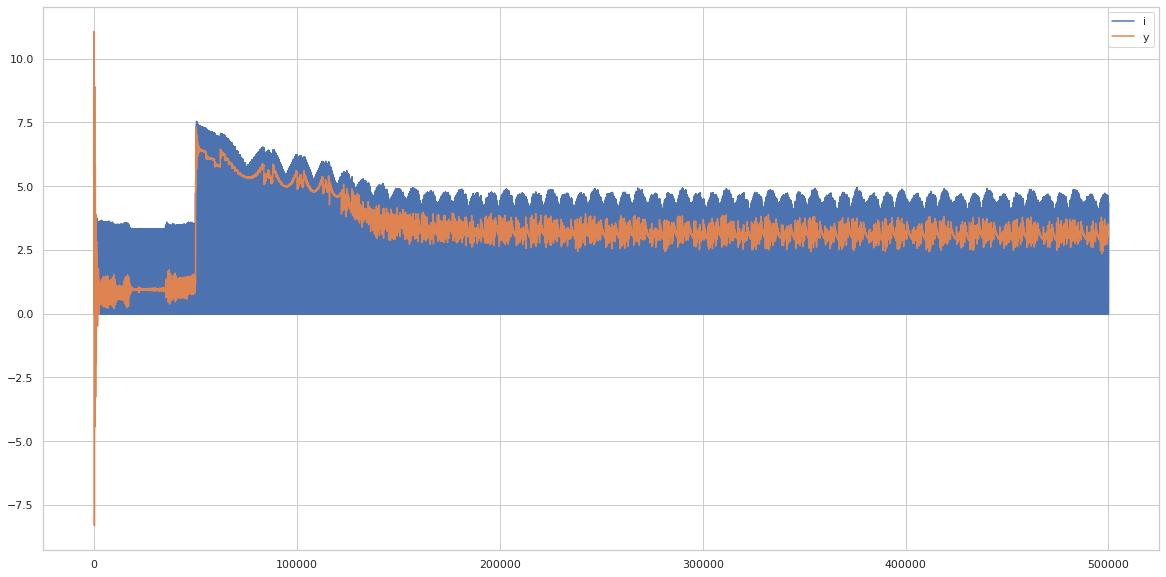

In [69]:
df[xynames].plot()

Target frequency:

In [70]:
from scipy.fft import fft, fftfreq
def plot_frequency(array, color="C0"):
  N = array.size
  SAMPLE_RATE = 5e5

  yf = fft(array)
  xf = fftfreq(N, 1 / SAMPLE_RATE)

  plt.plot(xf, np.abs(yf), color=color)
  plt.show()

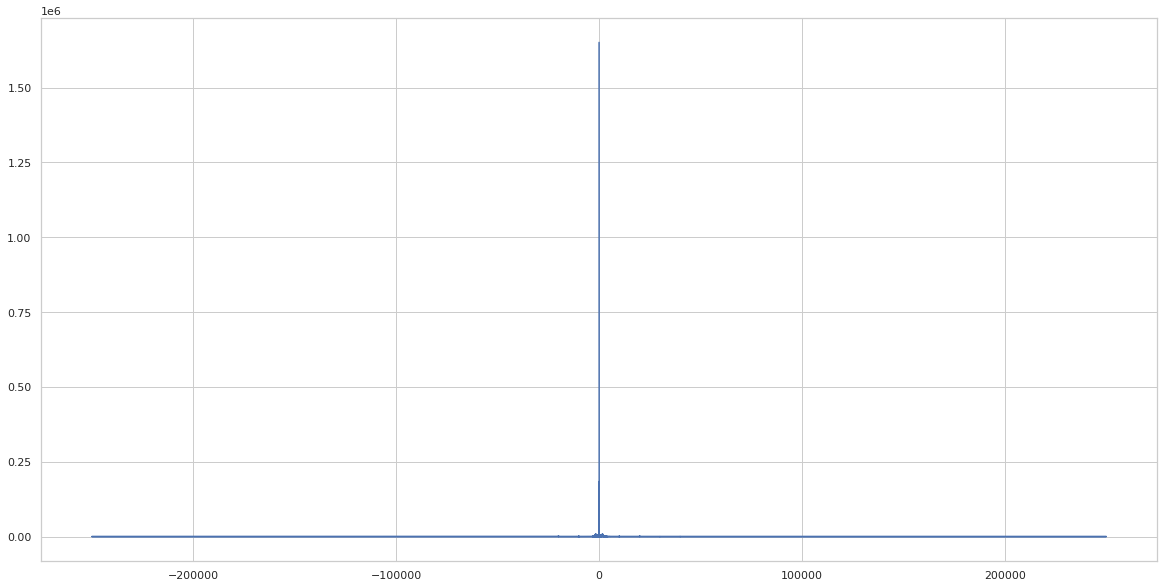

In [71]:
plot_frequency(df.y.to_numpy())

i_shunt frequency:

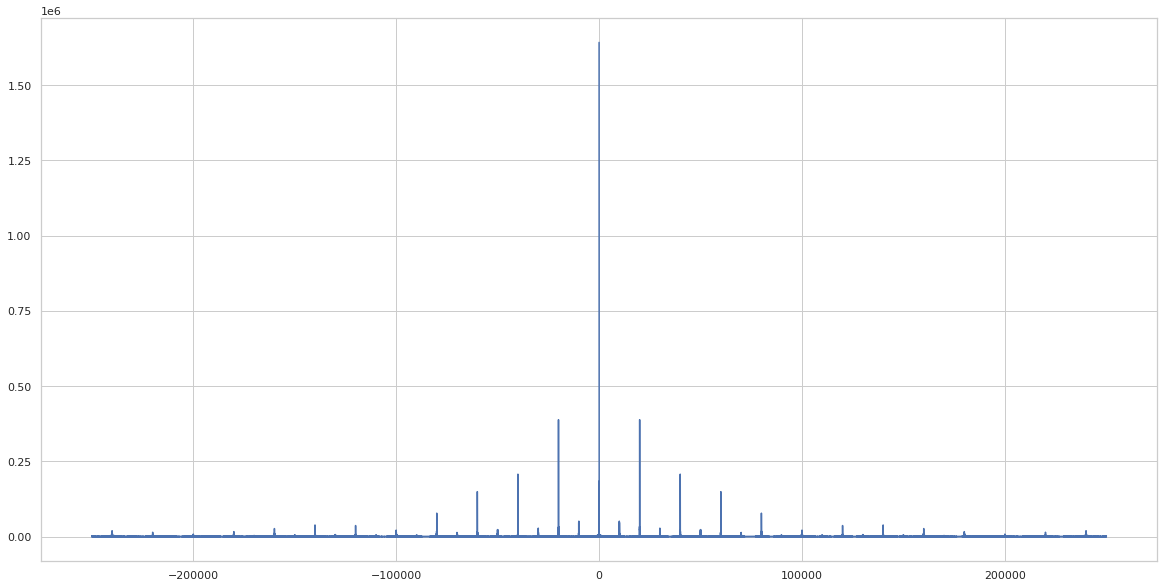

In [72]:
plot_frequency(df.i.to_numpy())

Una prima situazione interessante:

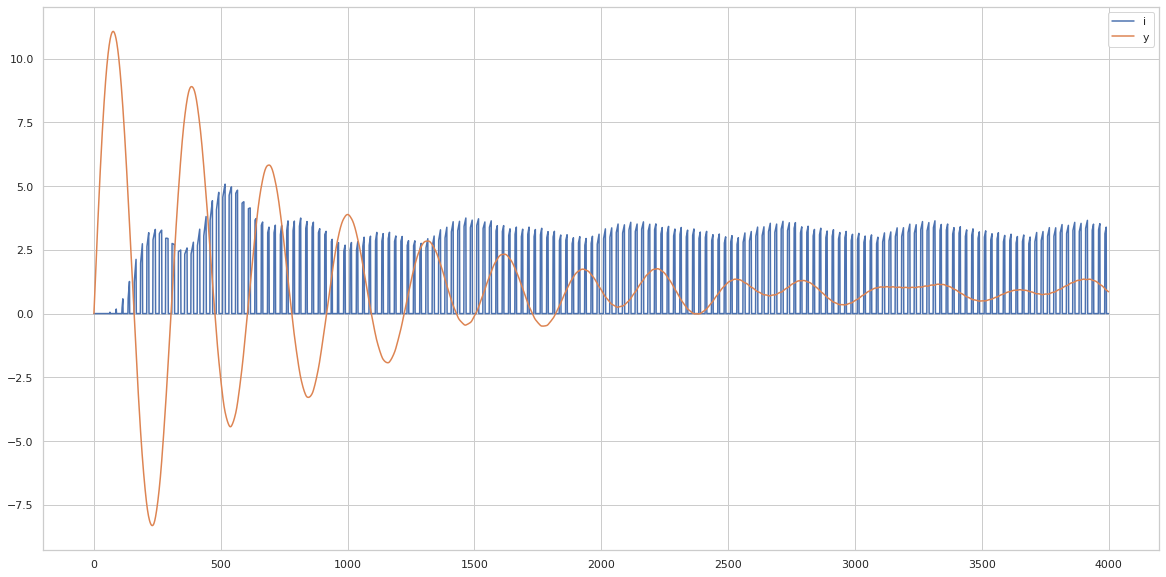

In [73]:
df[xynames].iloc[:int(4e3)].plot()

Taglio il primo salto a vuoto:

In [74]:
def cut_df(df, length):
  return df.iloc[int(length):]

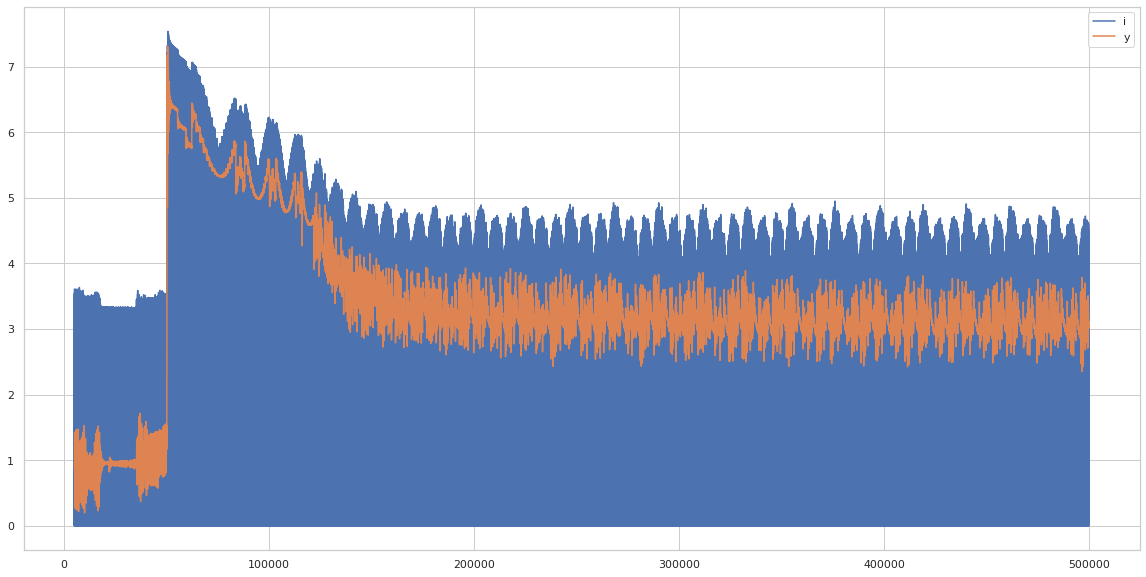

In [75]:
df_cut = cut_df(df, 5e3)
df_cut[xynames].plot()

### Moving average

In [76]:
def moving_average(df_, roll_value):
  df_wrk = df_.copy()
  df_wrk[xynames[0]] = df_wrk.i.rolling(roll_value).mean()
  return df_wrk

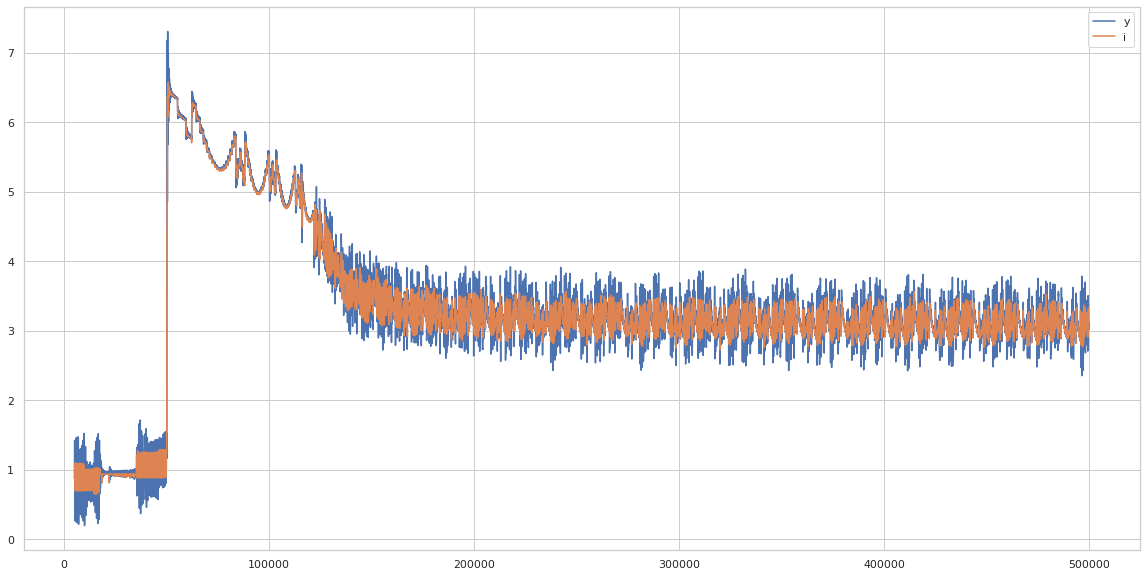

In [77]:
df_ma = moving_average(df_cut.copy(), 50)
df_ma[["y", "i"]].plot()

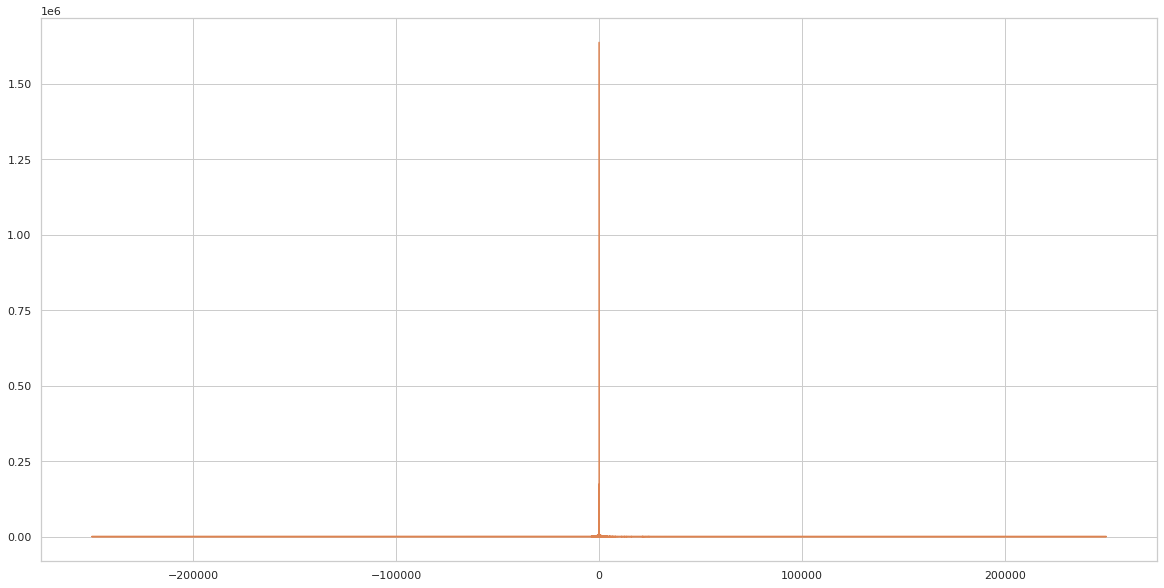

In [78]:
plot_frequency(df_ma.i.dropna().to_numpy(), color="C1")

In [79]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_ma.dropna()["i"], df_ma.dropna()["y"])

0.030333786062197825

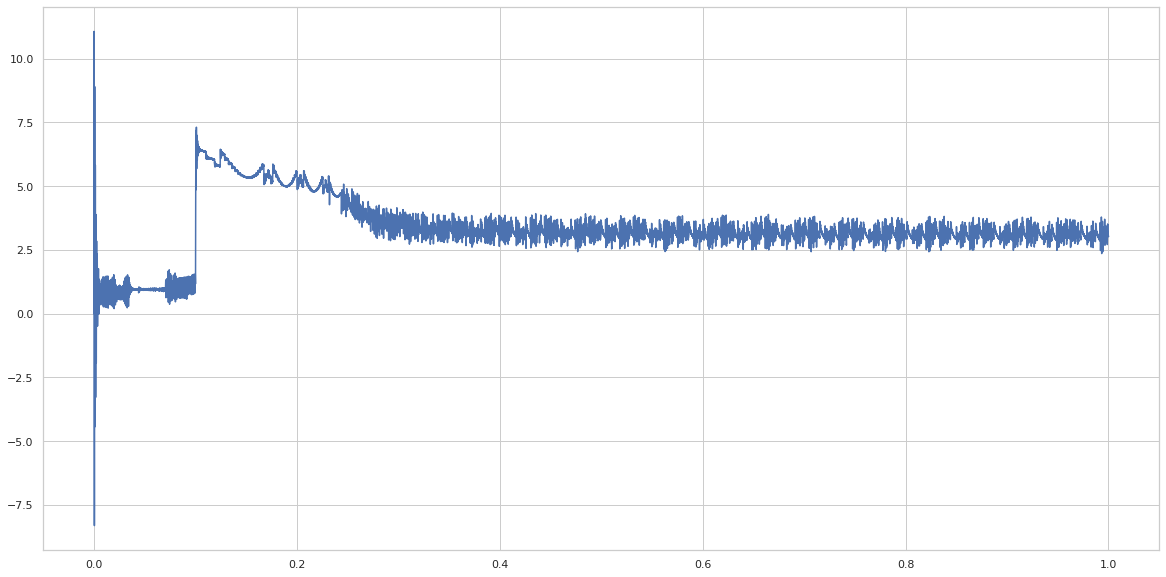

In [80]:
plt.plot(np.linspace(0,1, df.y.size), df.y)

In [81]:
optuna_test = False
if optuna_test:
  !pip install optuna
  import optuna

  def objective(trial):
      x = trial.suggest_int('x', 1, 1000)
      df_ma = moving_average(df_cut.copy(), x)
      return mean_squared_error(df_ma.dropna()["i"], df_ma.dropna()["y"])

  study = optuna.create_study()
  study.optimize(objective, n_trials=500)

In [82]:
if optuna_test:
  study.best_params

### Full pipeline

In [83]:
def pipeline(df):
  cutted = cut_df(df, 5e3)
  ma = moving_average(cutted, 50)
  df_nona = ma.dropna()
  X_np = df_nona.drop(xynames[1], axis=1).values
  Y_np = df_nona[xynames[1]].values
  return X_np, Y_np

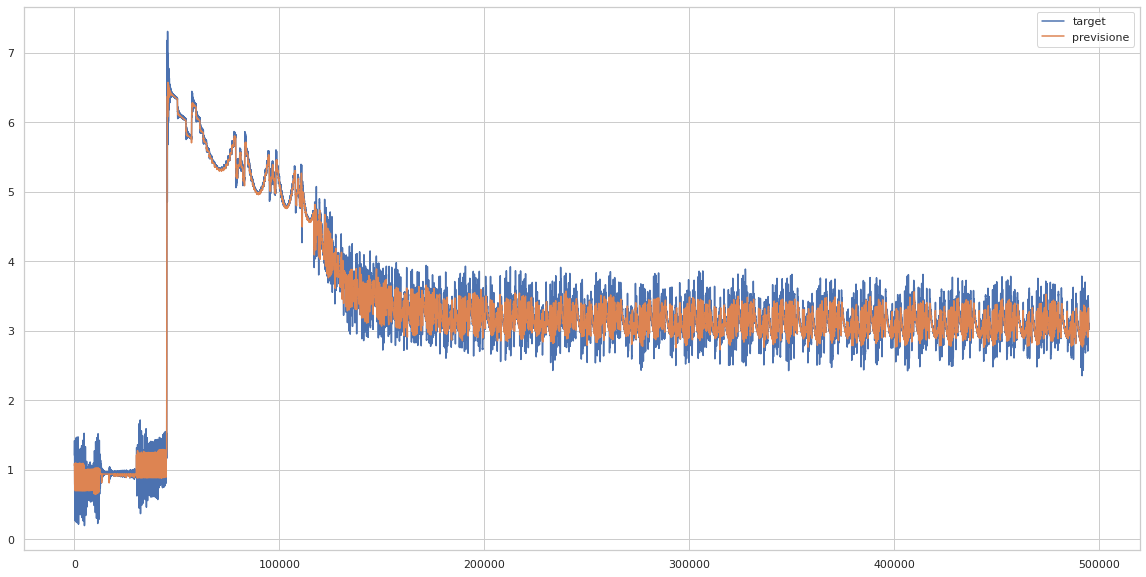

In [84]:
x_plt, y_plt = pipeline(df)
plt.plot(y_plt, label="target")
plt.plot(x_plt[:, 0], label="previsione")
plt.legend(loc="upper right")

Test pipeline only

0.14417940753087868

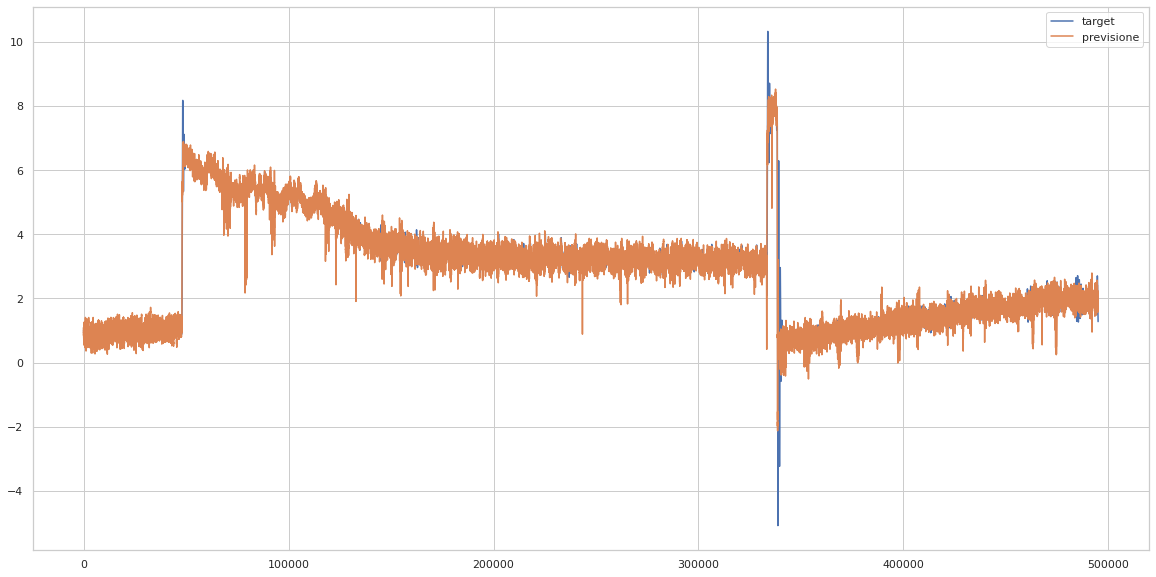

In [85]:
df_test = get_values_from_github("input_noise", "output_noise", "gate_noise")
X_t, y_t = pipeline(df_test)
plt.plot(y_t, label="target")
plt.plot(X_t[:, 0], label="previsione")
plt.legend(loc="upper right")

mean_squared_error(X_t[:,0], y_t)

0.13168387275316595

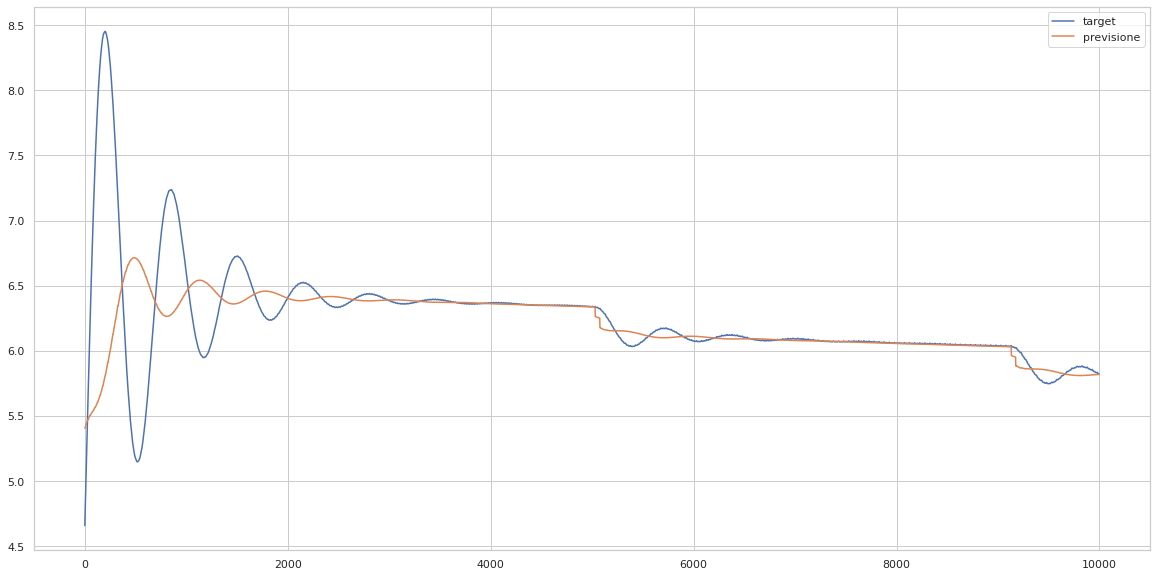

In [86]:
df_test = get_values_from_github("input_test", "output_test", "gate_test")
X_t, y_t = pipeline(df_test)
plt.plot(y_t[50000:60000], label="target")
plt.plot(X_t[50000:60000, 0], label="previsione")
plt.legend(loc="upper right")

mean_squared_error(X_t[:,0], y_t)

In [87]:
X_t = X_t[:,0]

# Metrics

In [88]:
from sklearn import metrics

### MSE

In [89]:
metrics.mean_squared_error(X_t, y_t)

0.13168387275316595

### NMSE

In [90]:
"{0:.6%}".format(metrics.mean_squared_error(X_t, y_t) / y_t.mean())

'3.797213%'

### MAE

In [91]:
metrics.mean_absolute_error(X_t, y_t)

0.14710474843144092

### MAPE

In [92]:
"{0:.3%}".format((np.abs(y_t-X_t)/y_t).sum()/y_t.size)

'6.104%'

### Max Error

In [93]:
metrics.max_error(X_t, y_t)

10.495838651600014

### Explained variance

In [94]:
"{0:.3%}".format(metrics.explained_variance_score(X_t, y_t))

'93.844%'

## Prova 1: Linear Regression

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
X, y = pipeline(df)

In [97]:
with_gate = "True" #@param["True", "False"]
if not bool(with_gate):
  X = X[:, 0]

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Linear Regression

In [99]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.9761970437419603

In [100]:
reg.coef_

array([0.998734])

0.030056854956330422

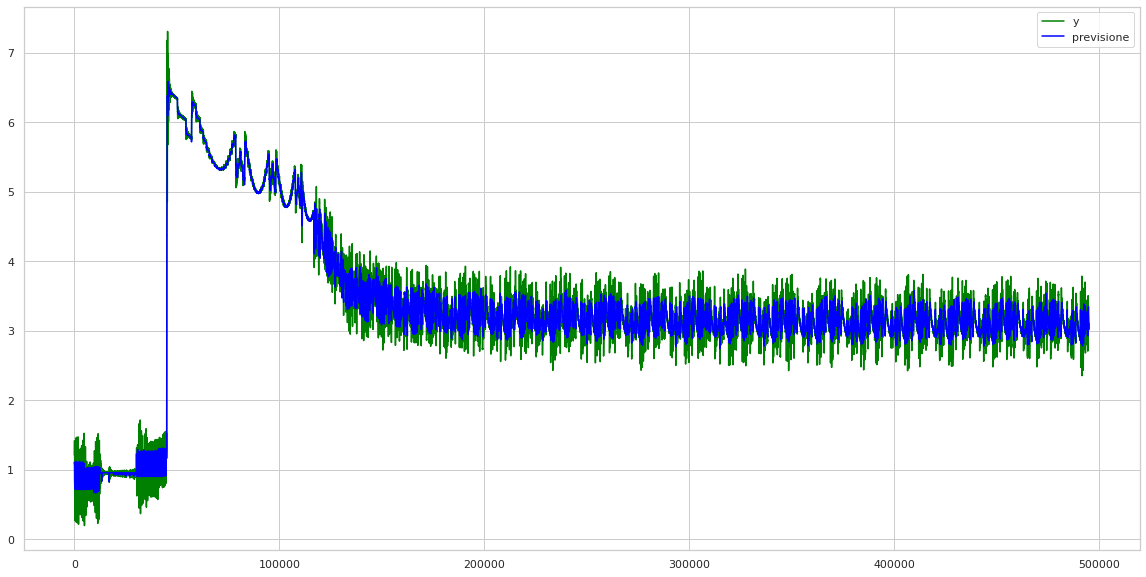

In [101]:
previsione = reg.predict(X)
plt.plot(y, color="green", label="y")
plt.plot(previsione, color="blue", label="previsione")
plt.legend(loc="upper right")

mean_squared_error(previsione, y)

Test 

In [106]:
df_test = get_values_from_github("input_test", "output_test", "gate_test")
X_t, y_t = pipeline(df_test)
X_t = X_t[:,0].reshape(-1,1)
reg.score(X_t, y_t)

0.9414970164697901

0.13135288636884698

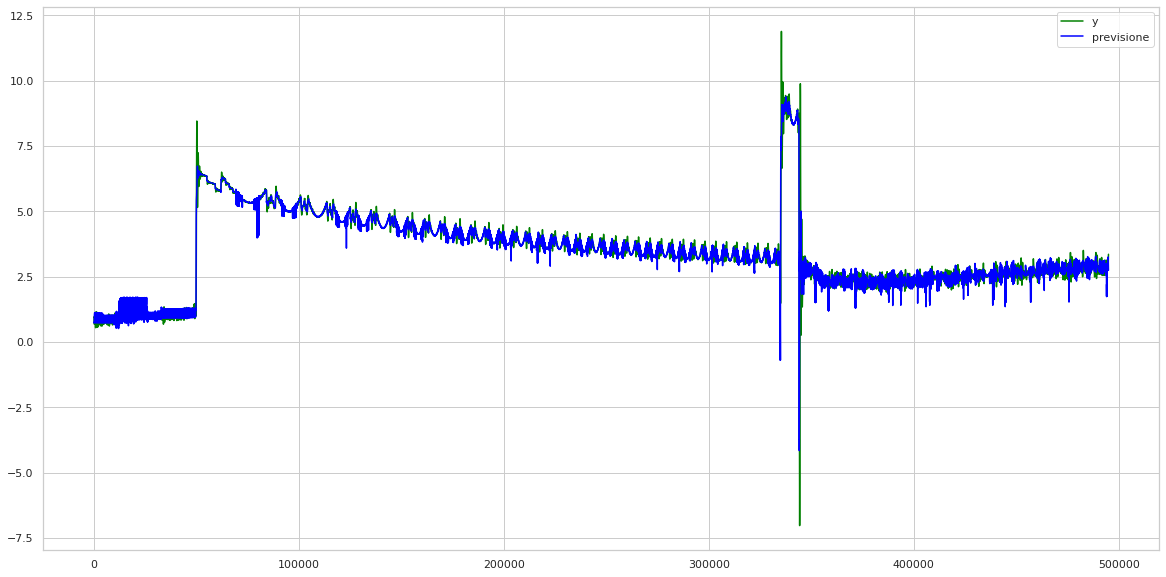

In [107]:
previsione = reg.predict(X_t)
plt.plot(y_t, color="green", label="y")
plt.plot(previsione, color="blue", label="previsione")
plt.legend(loc="upper right")
mean_squared_error(previsione, y_t)

### Test con Elastic Net

In [108]:
from sklearn.linear_model import ElasticNet
clf = ElasticNet(alpha=0.1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9704589596960838

0.03738691372590611

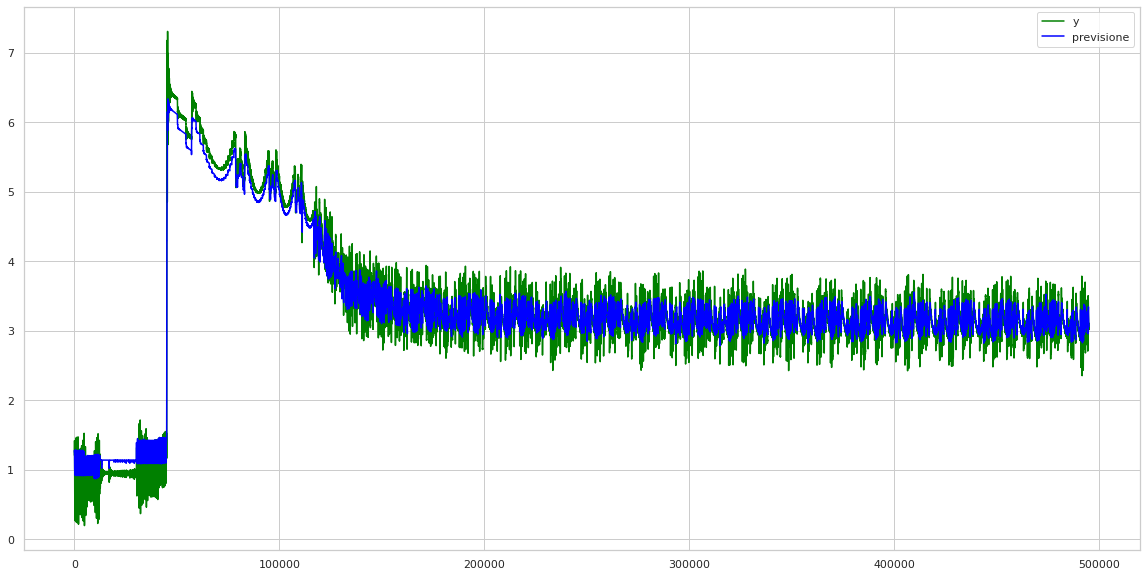

In [109]:
previsione = clf.predict(X)
plt.plot(y, color="green", label="y")
plt.plot(previsione, color="blue", label="previsione")
plt.legend(loc="upper right")
mean_squared_error(previsione, y)

### Test con Bayes

In [110]:
from sklearn.linear_model import BayesianRidge
clf = BayesianRidge()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9761970437295443

0.03005685496153767

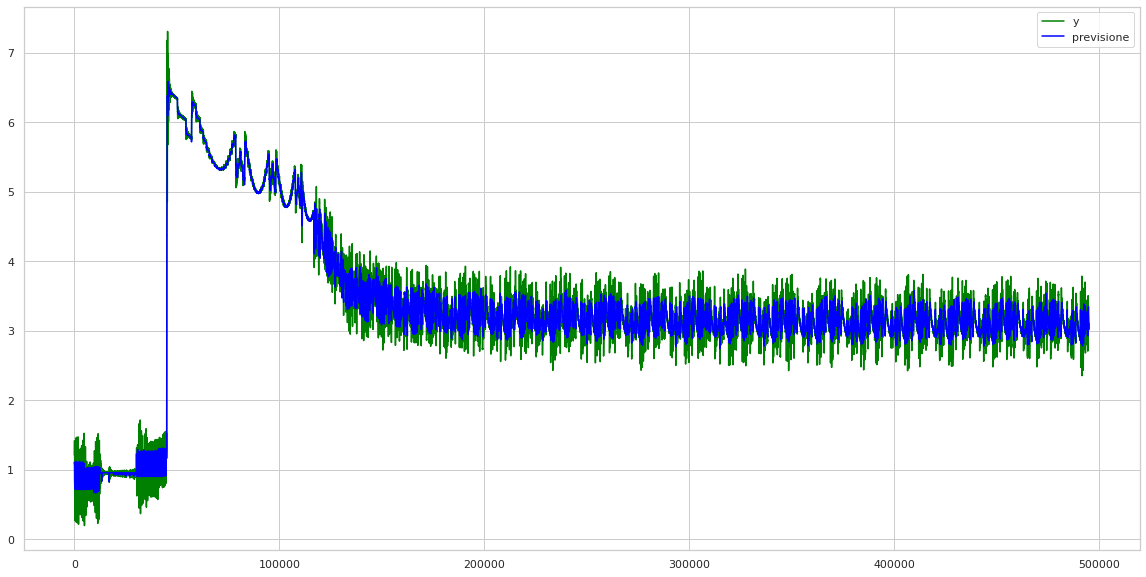

In [111]:
previsione = clf.predict(X)
plt.plot(y, color="green", label="y")
plt.plot(previsione, color="blue", label="previsione")
plt.legend(loc="upper right")
mean_squared_error(previsione, y)

### Kernel approx

errore e non posso riavviare il kernel https://stackoverflow.com/questions/56540967/sklearn-model-selection-error-importerror-cannot-import-name-approximate-mod

In [112]:
# from sklearn.kernel_approximation import PolynomialCountSketch
# from sklearn.linear_model import SGDClassifier
# ps = PolynomialCountSketch(degree=3, random_state=1)
# X_features = ps.fit_transform(X_train)
# clf = SGDClassifier(max_iter=10, tol=1e-3)
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)

## Prova 2: NN

### Linear Regression as a pre processing step

In [113]:
from tensorflow import keras
tfkl = keras.layers

In [114]:
X_linreg = X.copy()
X_linreg[:, 0] = reg.predict(X)
X_train, y_train = X_linreg, y

In [115]:
def build_nn_pre_linreg(input_shape, loss, opt):
  
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    hidden_layer1 = tfkl.Dense(units=64, activation='relu', name='Hidden1')(input_layer)
    output_layer = tfkl.Dense(units=1, activation='linear', name='Output')(hidden_layer1)

    model = keras.Model(inputs=input_layer, outputs=output_layer, name='RNN')

    model.compile(loss=loss, optimizer=opt)

    return model

In [116]:
input_shape = X_train.shape[1:]
loss = keras.losses.MeanSquaredError()
learning_rate = 0.01
optimizer = keras.optimizers.SGD(learning_rate)

In [117]:
batch_size = 64
epochs = 5

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1)]               0         
                                                                 
 Hidden1 (Dense)             (None, 64)                128       
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


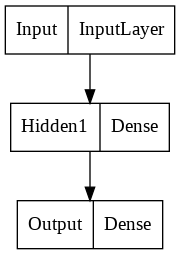

In [118]:
nn_pre_linreg = build_nn_pre_linreg(input_shape, loss, optimizer)
nn_pre_linreg.summary()
keras.utils.plot_model(nn_pre_linreg)

In [119]:
nn_pre_linreg.fit(
    x = X_train,
    y = y_train, 
    batch_size = batch_size,
    epochs = epochs,
)

Epoch 1/5
7734/7734 [==============================] - 12s 1ms/step - loss: 0.0312
Epoch 2/5
7734/7734 [==============================] - 11s 1ms/step - loss: 0.0302
Epoch 3/5
7734/7734 [==============================] - 11s 1ms/step - loss: 0.0302
Epoch 4/5
7734/7734 [==============================] - 11s 1ms/step - loss: 0.0302
Epoch 5/5
7734/7734 [==============================] - 11s 1ms/step - loss: 0.0302


In [120]:
nn_pre_linreg.save("modello_trainato")

INFO:tensorflow:Assets written to: modello_trainato/assets


INFO:tensorflow:Assets written to: modello_trainato/assets


In [121]:
predizione = nn_pre_linreg.predict(X_train)

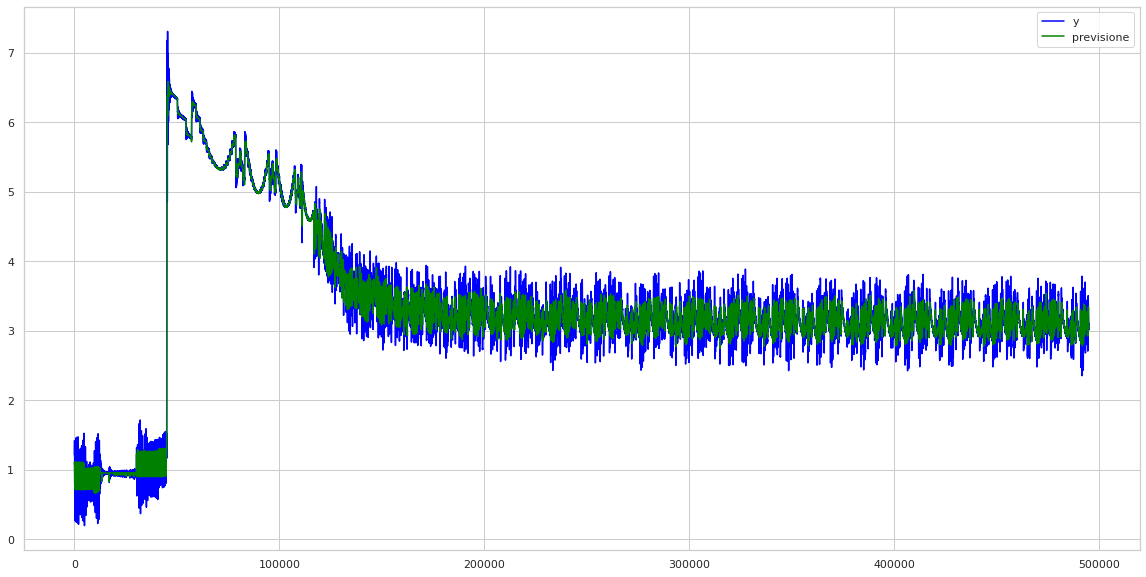

In [122]:
plt.plot(y_train, color="blue", label="y")
plt.plot(predizione, color="green", label="previsione")
plt.legend(loc="upper right")

In [123]:
mean_squared_error(predizione, y_train)

0.03005861105640073

Test

In [125]:
df_test = get_values_from_github("input_test", "output_test", "gate_test")
X_t, y_t = pipeline(df_test)
X_linreg_t = X_t.copy()
X_linreg_t[:, 0] = reg.predict(X_t[:,0].reshape(-1,1))

In [128]:
predizione = nn_pre_linreg.predict(X_linreg_t[:,0])

0.12611529998100268

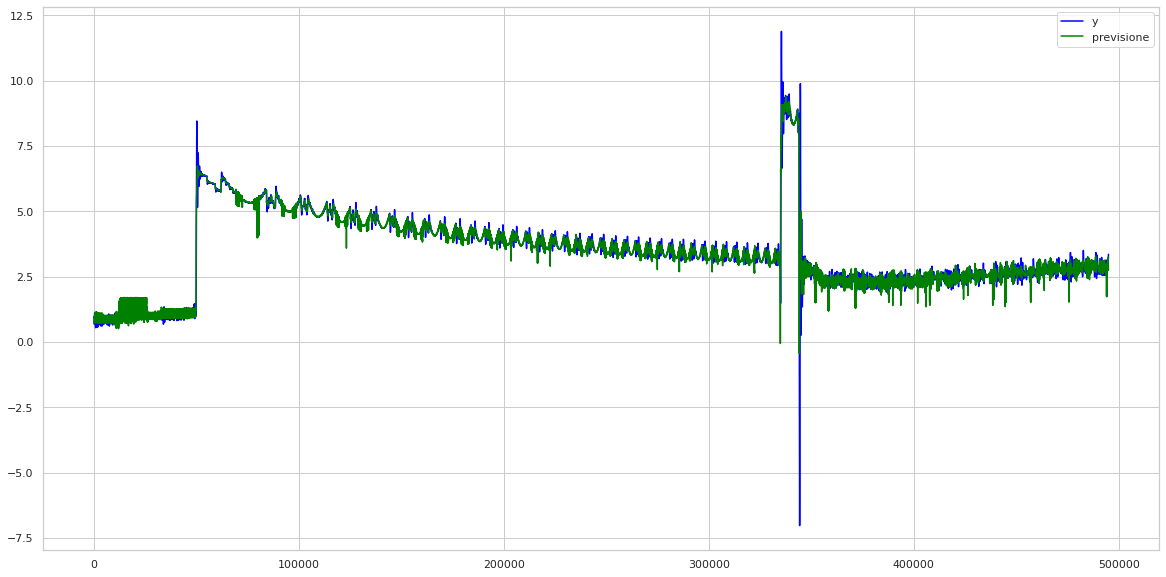

In [131]:
plt.plot(y_t, color="blue", label="y")
plt.plot(predizione, color="green", label="previsione")
plt.legend(loc="upper right")
mean_squared_error(predizione, y_t)